**Data 612: Project 3 - Matrix Factorization Methods<br>Christina Valore, Juliann McEachern, & Rajwant Mishra<br>Due: June 25, 2019**

<h1 align="center">Goodreads Recommender Systems</h1>

<h2 style="color:#088A68;">Getting Started</h2>

For project 3, we choose to continue our work with Goodreads books and build a recommender system that utilizes implicit matrix factorization techniques. As we have learned, singular value decomposition (SVD) matrices can be computationally expensive. Thus, our work will focus on a small subset of Goodreads book data that we previously explored in [Project 2](https://nbviewer.jupyter.org/github/jemceach/612-group/blob/master/project-2/report.ipynb). 

We will also compare the performance of our functions and calculations to the results generated by the `surprise` package. 

#### Python Dependencies

In [1]:
# The usual suspects 
import numpy as np, pandas as pd 

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Scikits packages
## Suprise!
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, SVD, Dataset, Reader, accuracy

## TFIDF
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


#### Data Preparation  

Data was loaded from our Project 2 repository collection of Goodread books, ratings, and tags. Tranformations then were used to combine the dataframes. 

In [2]:
# Load data into respective frames
books = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/books.csv',memory_map=True,engine='c', usecols=['goodreads_book_id','book_id', 'title', 'authors'])
ratings = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/ratings.tar.gz', 
                      compression='gzip', usecols=['user_id','book_id', 'rating'],memory_map=True,engine='c',skiprows=[5976480])
tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/book_tags.csv', engine='c', usecols=['goodreads_book_id','tag_id'],memory_map=True)
tag_id = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/tags.csv',memory_map=True,engine='c')

# transformations to join dataframes
book_tags = tags.set_index('tag_id').join(tag_id.set_index('tag_id')).merge(books, on='goodreads_book_id', how="inner")
data = ratings.set_index('book_id').join(books.set_index('book_id')).drop('goodreads_book_id', axis=1).reset_index()

In [3]:
# preview data 
data.head()

book_id  user_id  rating          authors  \
0        1     2886       5  Suzanne Collins   
1        1     6158       5  Suzanne Collins   
2        1     3991       4  Suzanne Collins   
3        1     5281       5  Suzanne Collins   
4        1     5721       5  Suzanne Collins   

                                     title  
0  The Hunger Games (The Hunger Games, #1)  
1  The Hunger Games (The Hunger Games, #1)  
2  The Hunger Games (The Hunger Games, #1)  
3  The Hunger Games (The Hunger Games, #1)  
4  The Hunger Games (The Hunger Games, #1)

#### Content Based Filtering

We revisited our collaborative based filtering function from Project 2 to optimize our subset of 10,000 books. We identified 25  titles related to "The Great Gatsby" and applied further transformations to find 100 users that rated the most books in our selection.  

In [4]:
# Reused CBF TFIDF to create best subset for analysis
CBF = book_tags.groupby(['goodreads_book_id','book_id','title','authors'],as_index=False).agg(lambda x:', '.join(x)).rename({'tag_name':'tags'}, axis=1).drop('goodreads_book_id', axis=1)
tdv = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english') # create vector
tfidf = tdv.fit_transform(CBF['tags']) # apply tfidf vector
cos = linear_kernel(tfidf, tfidf) # cosine similarity
i = pd.Series(data=CBF.index, index=CBF['title']) # index book_id for function

# Recommendation function 
def recommend(title):
    subset = CBF[['book_id','title', 'authors']] # set recommendation output
    idx = i[title] # set index to title
    #subset cos score
    score = pd.DataFrame(enumerate(cos[idx]), columns=['ID', 'score']).drop('ID', axis=1).sort_values('score', ascending = False).iloc[1:,]
    # recommend 50 books 
    top_n = score[1:26]
    rec = subset.iloc[top_n.index].join(top_n)
    rec.index = np.arange(1, len(rec) + 1)
    return rec

# Subset related titles and users with most rating contributions
sub=recommend("The Great Gatsby").drop('score',axis=1).merge(data, on=['book_id', 'title', 'authors'], how='inner')
s = sub.groupby(['user_id'])['book_id'].apply(list)
s = s[s.str.len() > 1].reset_index()
v = s.book_id.str.len().sort_values(ascending=False).index
v1 = s.reindex(v).reset_index(drop=True)
id=v1[1:101].drop('book_id',axis=1)
subset=id.merge(sub, on='user_id', how='inner')

# square-matrix
matrix=subset.pivot_table(index='user_id', columns='title', values='rating', aggfunc='count', fill_value=0)

# long-matrix 
reset_m=matrix.reset_index()
matrix_long = pd.melt(reset_m, id_vars='user_id', value_vars=list(matrix.columns[1:]), var_name='title', value_name='value')


#### User-Item Matrix

In [5]:
# view user-item matrix
matrix

title    A Farewell to Arms  A Separate Peace  A Streetcar Named Desire  \
user_id                                                                   
209                       0                 0                         0   
233                       0                 1                         1   
247                       1                 1                         1   
947                       1                 1                         1   
1590                      0                 0                         1   
2575                      1                 0                         1   
2617                      0                 0                         0   
2792                      0                 0                         1   
2895                      1                 0                         0   
3786                      0                 0                         0   
4234                      1                 0                         1   
4665                      1                 1                         0   
5336                      1                 1                         1   
6338                      1                 0                         1   
6342                      1                 1                         0   
6617                      1                 0                         0   
6634                      1                 1                         1   
6707                      0                 1                         0   
6715                      1                 1                         0   
7410                      1                 0                         0   
7801                      1                 0                         0   
7955                      1                 0                         0   
8176                      0                 1                         0   
8188                      0                 0                         1   
8679                      1                 0                         1   
8752                      1                 1                         0   
8871                      1                 0                         1   
9091                      1                 0                         0   
9193                      1                 0                         1   
9474                      1                 0                         1   
...                     ...               ...                       ...   
26336                     1                 0                         1   
26424                     1                 0                         1   
26898                     1                 1                         1   
28223                     1                 0                         1   
28756                     0                 1                         1   
28767                     0                 1                         0   
29394                     1                 0                         1   
33065                     1                 1                         0   
34977                     0                 0                         1   
35912                     1                 1                         0   
36002                     1                 0                         0   
36308                     1                 1                         0   
37470                     1                 0                         0   
37971                     1                 1                         0   
38095                     0                 1                         1   
39251                     1                 1                         1   
40859                     1                 1                         1   
41026                     1                 1                         0   
41454                     1                 1                         0   
43912                     0                 0                         1   
43956                    

#### Data Visualization

The `seaborn` catplot below shows us a boxplot of ratings per book title. From which, we can infer that most of these classic novels received high ratings amongst our subset of users.  

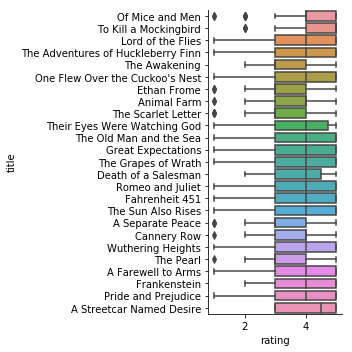

In [6]:
sns.catplot(x="rating", y="title", kind="box",data=subset);

We can also compare our matrix values to see proportion of books that have been rated by goodread users.

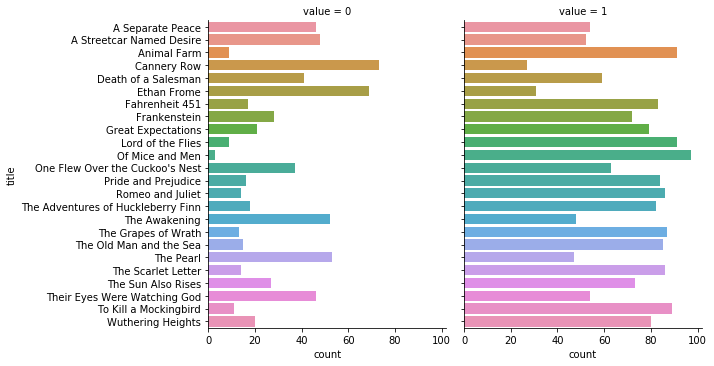

In [7]:
sns.catplot(x=None, y="title", col="value", kind="count",data=matrix_long);

<h2 style="color:#088A68;">Singular Value Decomposition</h2>

<h2 style="color:#088A68;">Alternating Least Squares Method</h2>
In case we choose to explore ALS technique as well ^^

<h2 style="color:#088A68;">Surprise!</h2>

<h2 style="color:#088A68;">Analysis</h2>

---
#### References: 
*  **[Goodbooks-10k:](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/)** A New Dataset for Book Recommendations